In [ ]:
!pip install nengo-dl

In [ ]:
!pip install nengo

In [4]:
%matplotlib inline

from urllib.request import urlretrieve
from nengo_dl.graph_optimizer import noop_planner
# from tensorflow import image.gb_to_grayscale
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf

import nengo_dl
import cv2
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))

test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
# with nengo.Network() as net:
#   # input
#   inpt = nengo.Node (np.zeros(28*28))
#   #layer
#   conv_1 = nengo.Ensemble(n_neurons= 32, dimensions=1, neuron_type= nengo.SpikingRectifiedLinear())
#   nengo.Connection(inpt,conv_1.neurons,transform=nengo_dl.dists.Glorot() )

#   out = nengo.Node (size_in=10)
#   nengo.Connection(conv_1,out,transform=nengo_dl.dists.Glorot())

#   p_inpt = nengo.Probe(inpt)
#   p_out = nengo.Probe(out)

n_in = 784
n_hidden = 64
minibatch_size = 50

with nengo.Network() as net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

In [14]:
with nengo_dl.Simulator(net,minibatch_size = 200) as sim:
  # sim.compile(
  #       optimizer=tf.optimizers.RMSprop(0.001),
  #       loss={tf.losses.mse},
  #       metrics = ['accuracy']
  #   ),
  sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics = [tf.metrics.sparse_categorical_accuracy]),
  sim.fit(train_images, train_labels, epochs=10)
  sim.evaluate(test_images,test_labels)

  # save the parameters to file
  sim.save_params("./mnist_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/10
|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:1025: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Running for one timestep, but the network contains "


300/300 [==============================] - 5s 9ms/step - loss: 157.7618 - probe_loss: 157.7618 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
300/300 [==============================] - 3s 9ms/step - loss: 157.3754 - probe_loss: 157.3754 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 156.9888 - probe_loss: 156.9888 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/10
300/300 [==============================] - 3s 8ms/step - loss: 156.6030 - probe_loss: 156.6030 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/10
300/300 [==============================] - 3s 8ms/step - loss: 156.2166 - probe_loss: 156.2166 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/10
300/300 [==============================] - 3s 9ms/step - loss: 155.8306 - probe_loss: 155.8306 - probe_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 155.4446 - pr

50/50 [==============================] - 1s 7ms/step - loss: 154.1892 - probe_loss: 154.1892 - probe_sparse_categorical_accuracy: 0.0000e+00


In [18]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:1025: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Running for one timestep, but the network contains "


Accuracy after training: 0.0


Test accuracy: 8.50%


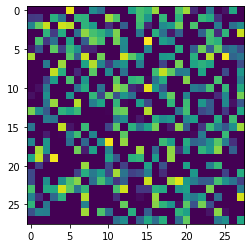

In [20]:

with nengo_dl.Simulator(net) as sim:
  sim.load_params('./mnist_params')
  sim.compile(loss={p_c: classification_accuracy})
  print(
    "Accuracy after training:",
    sim.evaluate(test_images, test_labels, verbose=0)["loss"],
)
  output = sim.predict(test_images[:200])
  predictions = np.argmax(output, axis=-1)
  accuracy = (predictions == test_labels[:200, 0, 0]).mean()
  print(f"Test accuracy: {100 * accuracy:.2f}%")
 
  plt.figure()
  plt.imshow(output[p_c][0].reshape((28, 28)))
  plt.show()